# Model Monitoring KPI Example
This notebook demonstrates how to use the `model_monitoring` module to define and analyze Key Performance Indicators (KPIs) across different data segments.

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from model_monitoring import (
    AnalysisDataBuilder,
    SegmentCategorical,
    SegmentCustom,
    calculate_statistics,
)
from model_monitoring.plotting import plot_segment_statistics, set_plot_theme

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Generate Synthetic Data

First, we'll create a synthetic dataset. This dataset mimics a typical insurance scenario with multiple coverages, predictions (risk premiums), and observed outcomes (targets/claims). The data is saved to a parquet file.

In [3]:
# --- Create a Synthetic Dataset ---
np.random.seed(42)
n_samples = 10000

# Create some numerical features
features = pd.DataFrame(
    {
        "age": np.random.randint(18, 70, n_samples),
        "income": np.random.gamma(2, 40000, n_samples),
        "credit_score": np.random.randint(300, 850, n_samples),
        "market_premium": np.random.uniform(0.1, 0.5, n_samples),
    }
)

# Create a categorical feature
features["region"] = np.random.choice(
    ["North", "South", "East", "West"], n_samples, p=[0.3, 0.2, 0.25, 0.25]
)

# --- Generate data for N=3 coverages in a wide format ---
N_coverages = 3
df = features.copy()

for i in range(N_coverages):
    cov_suffix = f"_{chr(65 + i)}"  # e.g., _A, _B, _C

    # --- Generate True Risk (rate for Poisson) ---
    true_risk_formula = (
        -4.0
        + (i * 0.1)
        + df["age"] / (20 + i * 2)
        - df["credit_score"] / (500 + i * 20)
        + df["income"] / 100000
    )
    true_risk_index = np.exp(true_risk_formula)

    # --- Generate a Slightly Incorrect Prediction ---
    prediction_formula = (
        -3.9
        + (i * 0.1)
        + df["age"] / (22 + i * 2)
        - df["credit_score"] / (550 + i * 20)
        + df["income"] / 110000
    )
    df[f"prediction{cov_suffix}"] = np.exp(prediction_formula)

    # --- Generate Target (claims) from the true risk ---
    df[f"target{cov_suffix}"] = np.random.poisson(true_risk_index)

# Add a single weight column
df["weight"] = 1.0

# Save to parquet
output_path = "../../data/segmentation_data.parquet"
df.to_parquet(output_path)

print(f"Synthetic data generated and saved to {output_path}")
df.head()

Synthetic data generated and saved to ../../data/segmentation_data.parquet


,age,income,credit_score,market_premium,region,prediction_A,target_A,prediction_B,target_B,prediction_C,target_C,weight
0,56,31626.419807,693,0.295256,West,0.097585,0,0.091178,0,0.087754,0,1.0
1,69,94350.676790,565,0.230289,East,0.393303,0,0.346978,1,0.317891,0,1.0
2,46,34226.773664,803,0.112133,South,0.051926,0,0.050744,0,0.050761,0,1.0
3,32,189107.488476,433,0.410269,North,0.220123,0,0.221539,0,0.226736,1,1.0
4,60,32588.089714,325,0.305161,South,0.230528,0,0.207231,0,0.192646,0,1.0


## 2. Configure the Analysis

Now, we set up the analysis by defining the coverages, segmentation strategies, and data treatments.

### Prediction & Target Mapping
We create a dictionary to map each coverage to its corresponding prediction, target, and weight columns.

In [4]:
pred_dict = {
    "A": {"sel_col": "weight", "pred_col": "prediction_A", "target_col": "target_A"},
    "B": {"sel_col": "weight", "pred_col": "prediction_B", "target_col": "target_B"},
    "C": {"sel_col": "weight", "pred_col": "prediction_C", "target_col": "target_C"},
}

### Segmentation Strategies
We define how to segment the data. We can create segments from categorical features or by binning numerical features.

In [5]:
segments = [
    # Segment for Age with custom bins
    SegmentCustom(
        seg_col="age",
        seg_name="age_group",
        bins=[18, 30, 45, 60, 75],
        bin_labels=["18-29", "30-44", "45-59", "60+"],
    ),
    # Segment for Income with 5 equal-width bins
    SegmentCustom(seg_col="income", seg_name="income_level", bins=5),
    # Segment for Region (each category is a segment)
    SegmentCategorical(seg_col="region", seg_name="region_segment"),
]
print(f"{len(segments)} segments defined.")

3 segments defined.


### Initialize Analysis and Apply Treatments
We initialize the `AnalysisDataBuilder` object, which orchestrates the data loading, treatment, and segmentation. Treatments are applied to the data, such as iso resources scaling of predictions or aggregating totals.

In [6]:
# Initialize AnalysisDataBuilder with the data path
lr_analysis = AnalysisDataBuilder(data=output_path, extra_cols=["market_premium"])

# Add treatments - now you can use either string names or direct class instances
lr_analysis.add_treatment("IsoResourceScaling", pred_dict)
lr_analysis.add_treatment("AddTotalCoverage", pred_dict)
lr_analysis.add_treatment("AddTotalCoverage", pred_dict, suffix="_iso")

# You can see available treatments:
print(f"Available treatments: {lr_analysis.list_available_treatments()}")

# Add segments
for s in segments:
    lr_analysis.add_segment(s)

# Load data and apply all defined steps
lr_analysis.load_data()
lr_analysis.apply_treatments()
lr_analysis.apply_segments()

print("Analysis configured. Treated and segmented data is ready.")
lr_analysis.db.head()

Available treatments: ['IsoResourceScaling', 'AddTotalCoverage', 'PairwiseIsoResourceScaling']
Analysis configured. Treated and segmented data is ready.


,market_premium,weight,target_B,target_A,prediction_C,prediction_A,prediction_B,target_C,age,income,region,prediction_A_iso,prediction_B_iso,prediction_C_iso,target_total,prediction_total,prediction_total_iso,age_group,income_level,region_segment
0,0.295256,1.0,0,0,0.087754,0.097585,0.091178,0,56,31626.419807,West,0.117509,0.097863,0.098152,0,0.276517,0.313524,45-59,"[220.929, 109734.013)",West
1,0.230289,1.0,1,0,0.317891,0.393303,0.346978,0,69,94350.676790,East,0.473603,0.372416,0.355559,1,1.058171,1.201579,60+,"[220.929, 109734.013)",East
2,0.112133,1.0,0,0,0.050761,0.051926,0.050744,0,46,34226.773664,South,0.062528,0.054465,0.056776,0,0.153431,0.173768,45-59,"[220.929, 109734.013)",South
3,0.410269,1.0,0,0,0.226736,0.220123,0.221539,1,32,189107.488476,North,0.265066,0.237781,0.253603,1,0.668398,0.756450,30-44,"[109734.013, 219247.098)",North
4,0.305161,1.0,0,0,0.192646,0.230528,0.207231,0,60,32588.089714,South,0.277595,0.222424,0.215474,0,0.630406,0.715494,60+,"[220.929, 109734.013)",South


## 3. Calculate Statistics (KPIs)

With the data prepared, we can now define and calculate our KPIs. We can compute simple statistics for our analysis.

In [7]:
# --- Define Statistics to Calculate ---
func_dict = {
    "aggregations": {
        "prediction_total": ("weighted_mean", ["prediction_total", "weight", "weight"]),
        "prediction_total_iso": (
            "weighted_mean",
            ["prediction_total_iso", "weight", "weight"],
        ),
        "target_total": ("observed_charge", ["target_total", "weight", "weight"]),
        "ELR": ("e_lr", ["prediction_total_iso", "weight", "weight", "market_premium"]),
        "LR": ("lr", ["target_total", "weight", "weight", "market_premium"]),
        "gini": ("gini", ["target_total", "prediction_total", "weight", "weight"]),
        "exposure(k)": (lambda df, e: df[e].sum() / 1000, ["weight"]),
    },
    "post_aggregations": {
        "S/PP": ("division", ["target_total", "prediction_total_iso"]),
        "diffLR-ELR": ("subtraction", ["LR", "ELR"]),
    },
}

# Calculate statistics
dict_stats, agg_stats = calculate_statistics(lr_analysis, func_dict, bootstrap=False)

print("--- Overall Statistics ---")
agg_stats

--- Overall Statistics ---


prediction_total         0.471967
prediction_total_iso     0.535100
target_total             0.535100
ELR                      1.789599
LR                       1.789599
gini                     0.536704
exposure(k)             10.000000
S/PP                     1.000000
diffLR-ELR               0.000000
dtype: float64

Here are the statistics for the `age_group` segment:

In [8]:
dict_stats["age_group"]

,prediction_total,prediction_total_iso,target_total,ELR,LR,gini,exposure(k),S/PP,diffLR-ELR,segment
age_group,,,,,,,,,,
18-29,0.166148,0.187868,0.161535,0.623343,0.535972,0.424993,2.241,0.859834,-0.087372,age_group
30-44,0.298072,0.337468,0.313111,1.137197,1.055118,0.440756,2.967,0.927823,-0.082079,age_group
45-59,0.561142,0.636211,0.641319,2.131861,2.148978,0.401249,2.880,1.008029,0.017117,age_group
60+,0.965933,1.096460,1.157427,3.647879,3.850711,0.427845,1.912,1.055603,0.202833,age_group


## 4. Visualize Segmented KPIs

Finally, we visualize the calculated KPIs. The plotting module is flexible and allows for creating multi-panel reports with different chart types.

### Set Plotting Theme
We can set a consistent theme for all our plots.

In [9]:
set_plot_theme(
    annotation_fontsize=14, style="ggplot", target_color="#1E1D25", h_line_style=":"
)

### Generate Visualization Report
We define a list of panels to create a comprehensive report. Each panel can be customized (plot type, colors, etc.). Here we show a report with line plots, confidence interval bands, and a bar chart for exposure.

--- Report for age_group ---


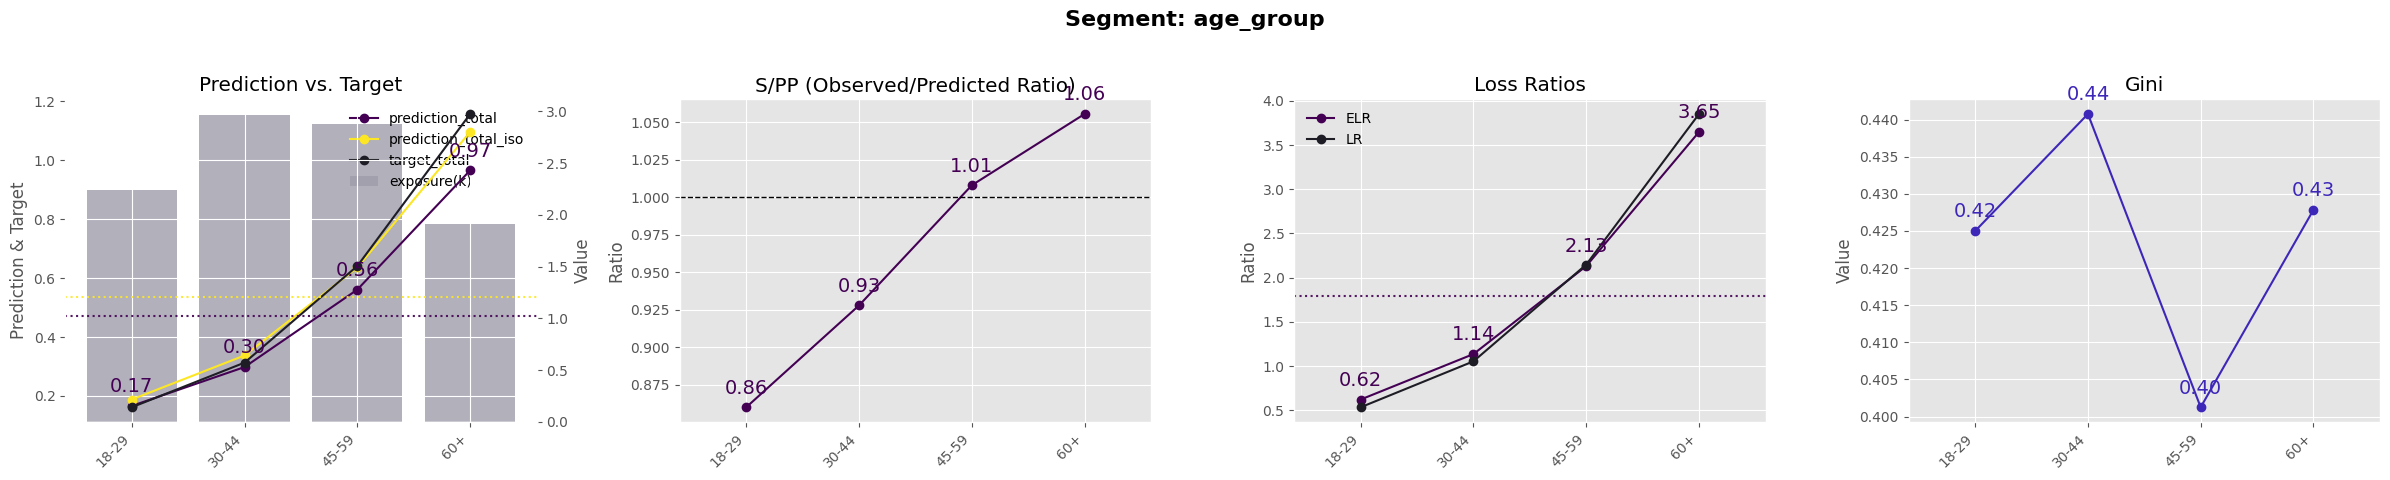

--- Report for income_level ---


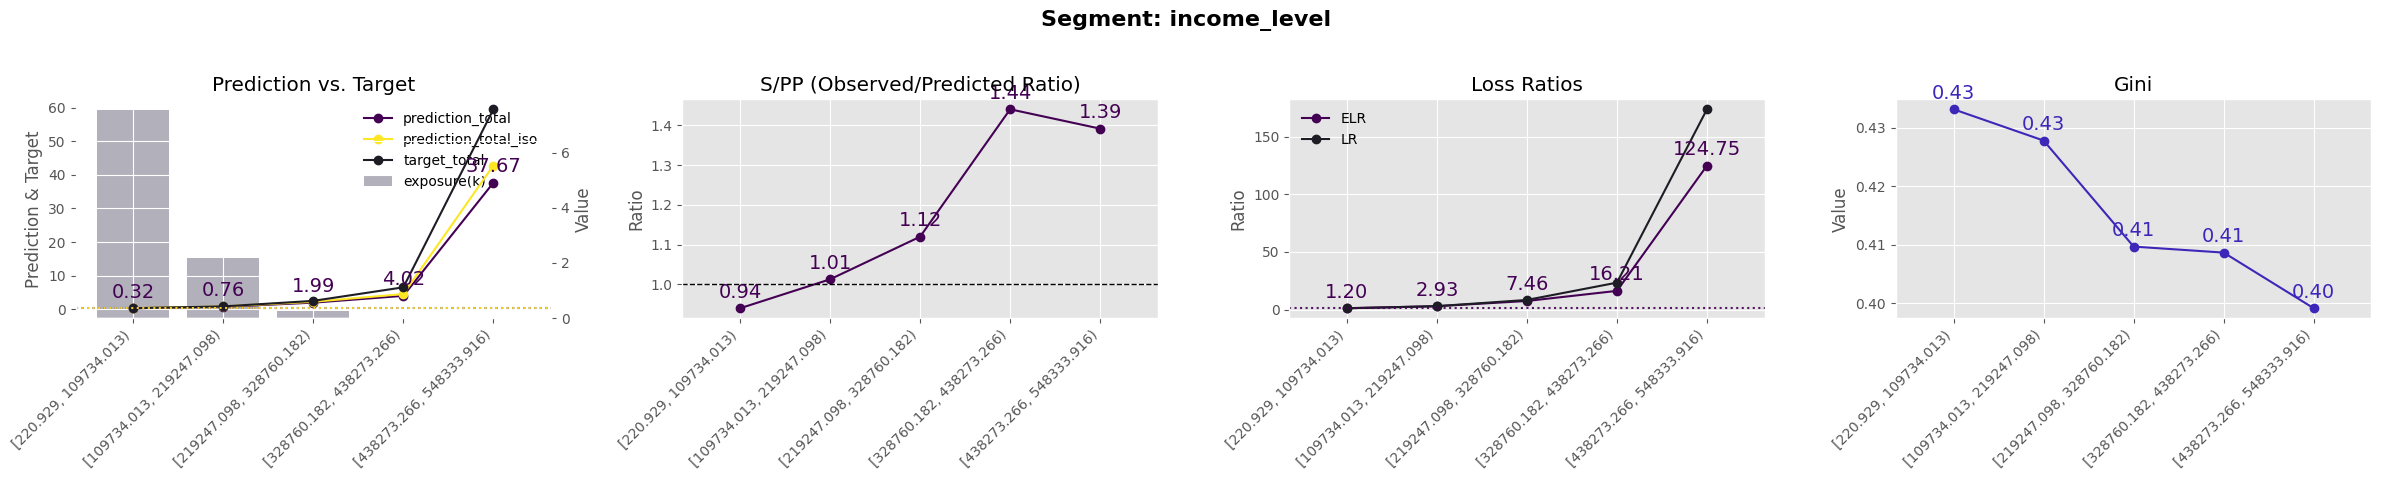

--- Report for region_segment ---


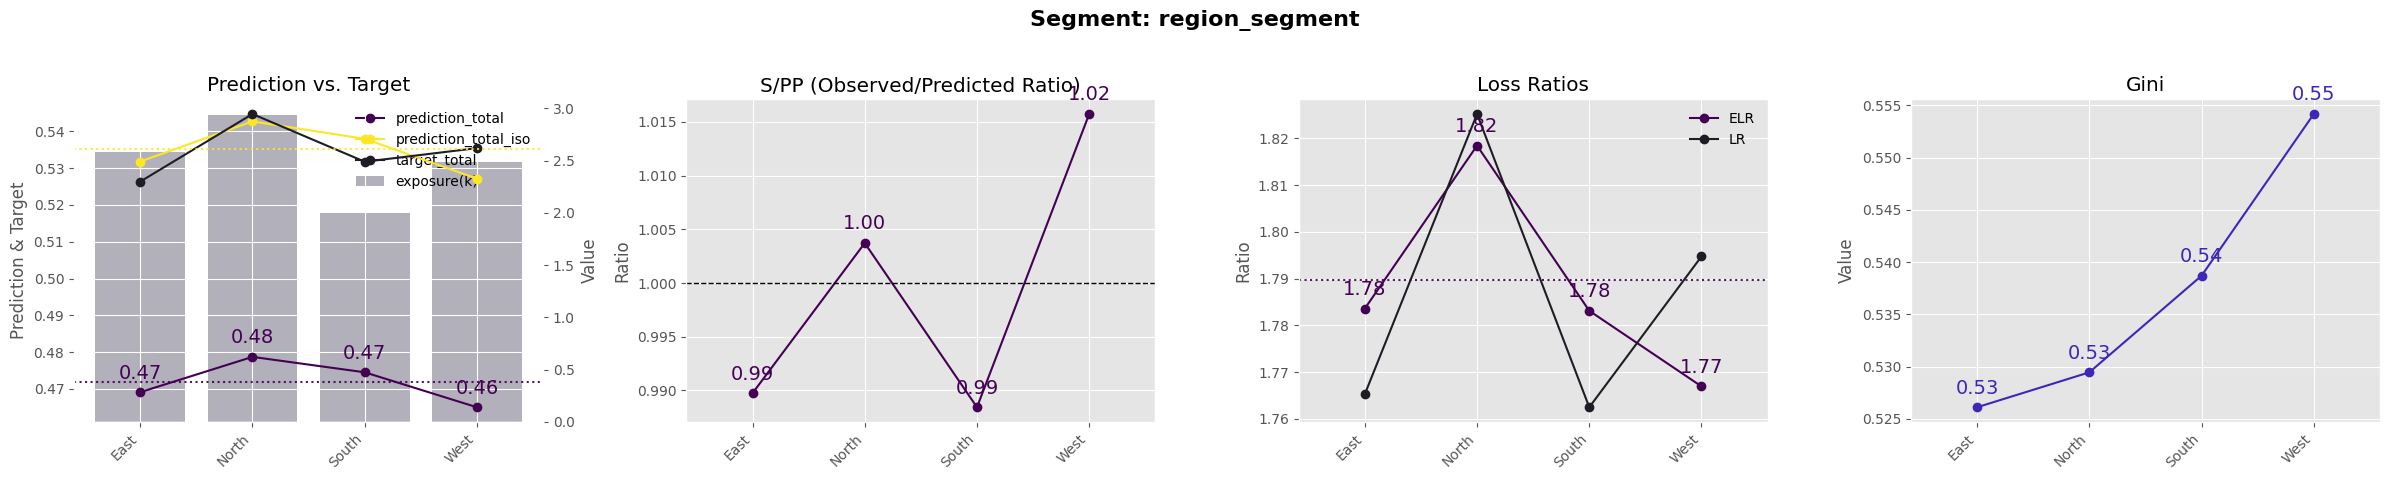

In [24]:
# Define the panels for the plot
report_panels = [
    {
        "title": "Prediction vs. Target",
        "type": "pred_vs_target",
        "pred_col": ["prediction_total", "prediction_total_iso"],
        "target_col": "target_total",
        "plot_type": "line",
        "show_mean_line": "all",
    },
    {
        "title": "S/PP (Observed/Predicted Ratio)",
        "type": "spp",
        "spp_col": ["S/PP"],
        "plot_type": "line",
        "show_mean_line": False,
    },
    {
        "title": "Loss Ratios",
        "type": "loss_ratios",
        "elr_col": ["ELR"],
        "lr_col": "LR",
        "plot_type": "line",
    },
    {
        "title": "Prediction vs. Target",  # As the title is reused, this panel will be a twin plot on the same axis
        "type": "exposure",
        "metric_col": "exposure(k)",
        "plot_type": "bar",
        "colors": ["#9F9DAA"],
    },
    {
        "title": "Gini",  # As the title is reused, this panel will be a twin plot on the same axis
        "type": "metric",
        "metric_col": "gini",
        "plot_type": "line",
        "colors": ["#3D27B9"],
    },
]


# Iterate over each segment's statistics and generate a plot
for segment_name, stats_df in dict_stats.items():
    print(f"--- Report for {segment_name} ---")
    plot_segment_statistics(stats_df, panel_configs=report_panels, agg_stats=agg_stats)

## 5. Bootstrapped Statistics

Now, let's re-calculate the statistics with bootstrapping enabled to get confidence intervals for our KPIs. This helps in understanding the uncertainty of our metrics.

In [23]:
# --- Recalculate statistics with bootstrapping ---
dict_stats_bs, agg_stats_bs = calculate_statistics(
    lr_analysis,
    func_dict,
    bootstrap=True,
    n_resamples=100,  # Using 100 samples for speed in this example
    ci_level=0.95,
)

print("--- Overall Bootstrapped Statistics (with 95% CI) ---")
agg_stats_bs

--- Overall Bootstrapped Statistics (with 95% CI) ---


prediction_total_low         0.459795
prediction_total             0.471967
prediction_total_up          0.490225
prediction_total_iso_low     0.521281
prediction_total_iso         0.535100
prediction_total_iso_up      0.555827
target_total_low             0.514920
target_total                 0.535100
target_total_up              0.572682
ELR_low                      1.736680
ELR                          1.789599
ELR_up                       1.860485
LR_low                       1.722028
LR                           1.789599
LR_up                        1.915399
gini_low                     0.514617
gini                         0.536704
gini_up                      0.565087
exposure(k)_low             10.000000
exposure(k)                 10.000000
exposure(k)_up              10.000000
S/PP_low                     0.974123
S/PP                         1.000000
S/PP_up                      1.032821
diffLR-ELR_low              -0.046178
diffLR-ELR                   0.000000
diffLR-ELR_u

Here are the bootstrapped statistics for the `age_group` segment, including confidence intervals.

In [25]:
dict_stats_bs["age_group"]

,segment,prediction_total_low,prediction_total,prediction_total_up,prediction_total_iso_low,prediction_total_iso,prediction_total_iso_up,target_total_low,target_total,target_total_up,...,gini_up,exposure(k)_low,exposure(k),exposure(k)_up,S/PP_low,S/PP,S/PP_up,diffLR-ELR_low,diffLR-ELR,diffLR-ELR_up
age_group,,,,,,,,,,,,,,,,,,,,,
18-29,age_group,0.159408,0.166148,0.172641,0.180244,0.187868,0.195212,0.143774,0.161535,0.175242,...,0.497318,2.174950,2.241,2.310150,0.777130,0.859834,0.934853,-0.136148,-0.087372,-0.040019
30-44,age_group,0.289190,0.298072,0.308386,0.327408,0.337468,0.349152,0.286631,0.313111,0.339872,...,0.484036,2.876750,2.967,3.045050,0.868716,0.927823,0.976542,-0.147507,-0.082079,-0.026628
45-59,age_group,0.544877,0.561142,0.582572,0.617775,0.636211,0.660508,0.615901,0.641319,0.676928,...,0.426350,2.802800,2.880,2.968825,0.971494,1.008029,1.041175,-0.061819,0.017117,0.088527
60+,age_group,0.910999,0.965933,1.065536,1.034093,1.096460,1.209549,1.064905,1.157427,1.345437,...,0.489663,1.835375,1.912,1.981150,1.010912,1.055603,1.108281,0.038781,0.202833,0.419732


### Visualize Bootstrapped KPIs with Confidence Intervals

Now we can visualize the KPIs with their confidence intervals. The `plot_segment_statistics` function will automatically detect the confidence interval columns and plot them as shaded bands.

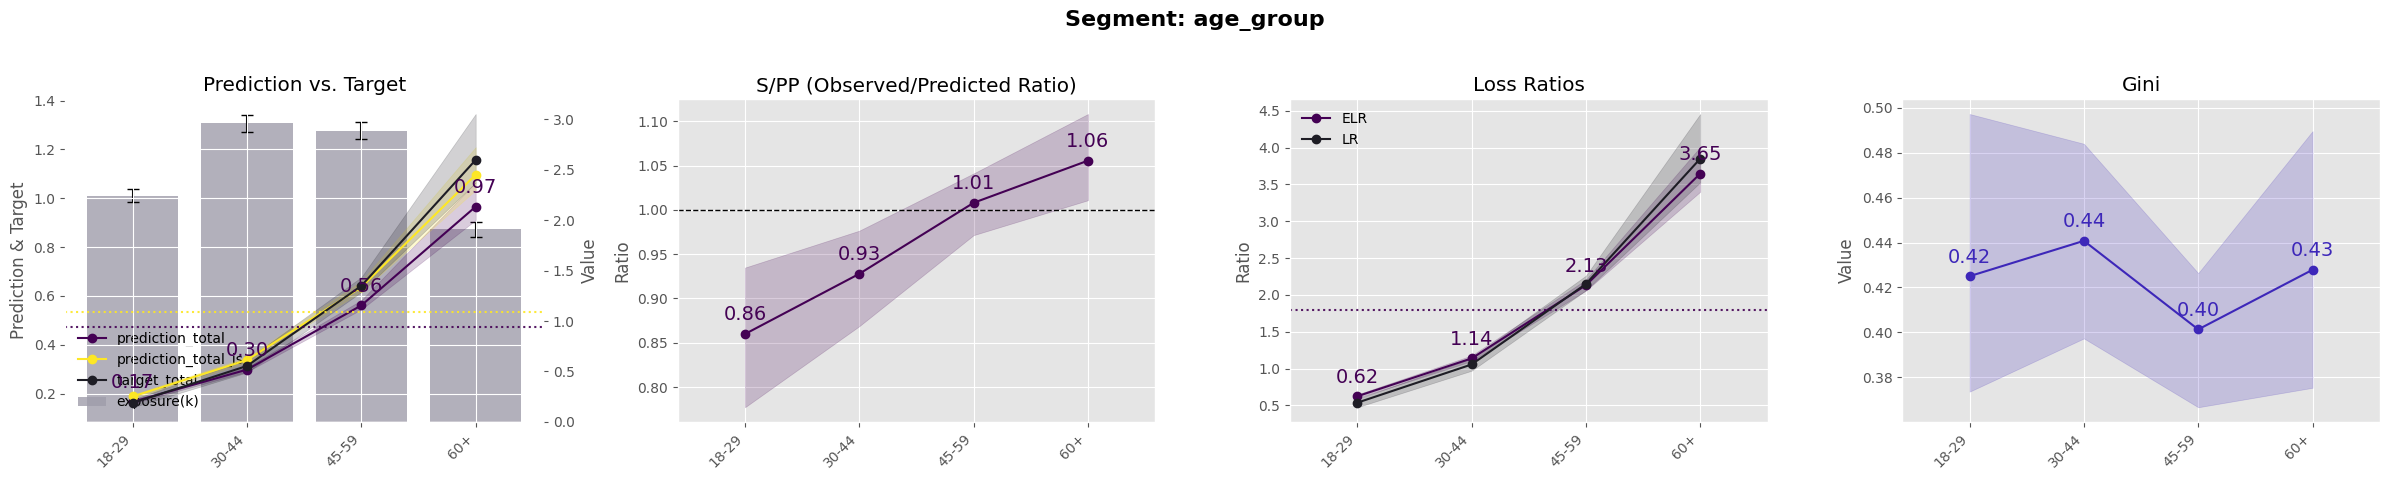

In [26]:
# Create a new report configuration to display confidence intervals
report_panels_bs = [{**panel, "show_ci": True} for panel in report_panels]


plot_segment_statistics(
    dict_stats_bs["age_group"], panel_configs=report_panels_bs, agg_stats=agg_stats_bs
)